In [1]:
import numpy as np
import math
import os
import pandas as pd
from operator import itemgetter
import pickle
from tqdm import tqdm
import scipy
import random
import yaml

import difflib
import string
import json

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
import seaborn as sns

import torch
from torch import Tensor
import datasets
from datasets import load_dataset
from embedding import BertHuggingfaceMLM
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset

from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, RIPA, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias
from unmasking_bias import PLLBias

from utils import CLFHead, SimpleCLFHead, CustomModel, CrowSPairsDataset, JigsawDataset, BiosDataset, MLMPipeline

/home/saschroeder/anaconda3/envs/plmbias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-04 15:28:56.091574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 15:28:56.120234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 15:28:56.120262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04

# TODO
- implement datasets (especially preprocessing (removing invalid samples, labeling bias types/ groups, providing neutral samples) + general dataset methods
  - jigsaw
- (!) bias manipulation:
  - mlm debias: need a wrapper for the model, with embedding -> (debias) -> mlm prediction pipeline, token-wise debiasing, problem: architecture specific names (only use bert and roberta?)
- evaluation
  1) correlation of extrinsic/ cosine bias on pre-trained data (+ head fine-tuning)
  2) debiasing/ bias amplification (parameter k) -> statistical test (+ correlation?): do cosine scores and extrinsic measure agree which models are more/less biased
  3) robustness (take the/ some models from 1), apply permutation test with different subsets of targets/samples or defining terms for cosine metrics

## TODO: Tuesday
- test debiasing (+amplification)with MLM head (see todos below), maybe first on CPU (code+plausibility)
- wrapper (see below) + simple CPU test
- how to save config?
- BIOS dataset with GAP score (test on small subset if GPU not ready)


### next steps:

- wrapper for CLF experiment (get training running and save the artifacts/ results)
- evaluate/visualize first mlm experiment

In [2]:
#mlm = BertHuggingfaceMLM(model_name='distilbert-base-uncased', batch_size=2)
pipeline = MLMPipeline(parameters={'debias': False, 'debias_k': 1, 'batch_size': 4}, model_name='distilbert-base-uncased')

Using bos_token, but it is not set yet.


In [5]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
with open('data/batch_size_lookup_1080.json', 'r') as f:
    batch_size_lookup = json.load(f)
    
with open('results/mlm_15133/config.json', 'r') as f:
    exp_config = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

cosine_scores = {'SAME': SAME, 'WEAT': WEAT, 'gWEAT': GeneralizedWEAT, 'DirectBias': DirectBias, 'MAC': MAC}


csp_dataset = CrowSPairsDataset(groups_by_bias_types, terms_by_groups)

Found cached dataset crows_pairs (file:///home/saschroeder/.cache/huggingface/datasets/crows_pairs/crows_pairs/1.0.0/33d1d2c8fb39ec51955a725d16f117ccbb733fc2adf2fad749b6442e6ed78a0e)


NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

In [4]:
texts = [sample['text'] for sample in csp_dataset.data]

In [5]:
# TODO: memory management

In [8]:
pipeline.embed(texts, average='mean')

100%|█████████████████████████████████████| 130/130 [00:01<00:00, 68.71it/s]


(517, 768)

In [10]:
pipeline.embed(texts).shape

100%|█████████████████████████████████████| 130/130 [00:01<00:00, 70.06it/s]


(517, 48, 768)

In [9]:
pipeline.predict(texts).shape

embed samples...


100%|████████████████████████████████████| 130/130 [00:01<00:00, 114.71it/s]


(517, 48, 30522)

In [115]:
from transformers import AutoTokenizer
mlm = BertHuggingfaceMLM(model_name='distilbert-base-uncased', batch_size=1)
tokenizer = mlm.tokenizer

tokens = tokenizer(["hello you", "bla bla", "yo"], return_tensors="pt", padding=True)#, truncation=True))
print(tokens)
tokens = tokens.to('cuda')

Using Bert with CUDA/GPU
{'input_ids': tensor([[  101,  7592,  2017,   102,     0,     0],
        [  101,  1038,  2721,  1038,  2721,   102],
        [  101, 10930,   102,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0]])}


In [116]:
out = mlm.model.distilbert(tokens['input_ids'], attention_mask=tokens['attention_mask'])
token_emb = out.hidden_states[-1] # batch_size, n_tokens, emb_dim
token_emb.size()

torch.Size([3, 6, 768])

In [117]:
token_emb

tensor([[[-0.1009, -0.0572,  0.1357,  ..., -0.1517,  0.2852,  0.2347],
         [-0.2298,  0.2290,  0.6259,  ..., -0.2124,  0.4092,  0.0174],
         [-0.6090, -0.3433,  0.9080,  ...,  0.2539,  0.3140, -0.1742],
         [ 0.8648,  0.1428, -0.3749,  ...,  0.2434, -0.5702, -0.3370],
         [ 0.0456, -0.1609,  0.4228,  ...,  0.0913,  0.1529,  0.0486],
         [ 0.0193, -0.0682,  0.4811,  ..., -0.0122,  0.1361,  0.0890]],

        [[-0.0625, -0.2308,  0.0440,  ...,  0.0306,  0.2220,  0.3473],
         [ 0.5259, -0.1319,  0.2800,  ...,  0.0785,  0.4980,  0.1530],
         [ 0.5018, -0.1743,  0.5687,  ...,  0.3794, -0.4854, -0.7349],
         [ 0.5973, -0.0306,  0.4547,  ...,  0.0367,  0.1565,  0.1949],
         [ 0.3835, -0.2670,  0.2983,  ...,  0.4385, -0.5946, -0.7579],
         [ 1.0897,  0.2114, -0.4150,  ...,  0.3253, -0.6404, -0.2243]],

        [[-0.1733, -0.1340,  0.2440,  ..., -0.1601,  0.1081,  0.3974],
         [-0.2043,  0.0301,  0.3751,  ..., -0.0329,  0.1115,  0.4631],
  

In [155]:
avg_emb = []
for batch_elem in range(token_emb.size()[0]):
    zeros = torch.argwhere(tokens.attention_mask[batch_elem] == 0)
    if zeros.size()[0] > 0:
        first_zero = int(zeros[0][0])
    else:
        first_zero = tokens.attention_mask[batch_elem].size()[0]
    avg_emb.append(torch.mean(token_emb[batch_elem][:first_zero], dim=0))
avg_emb = torch.stack(avg_emb)

In [157]:
avg_emb.size()

torch.Size([3, 768])

In [151]:
attention_repeat = torch.repeat_interleave(tokens.attention_mask, token_emb.size()[2]).reshape(token_emb.size())
mean_emb = torch.sum(token_emb*attention_repeat, dim=1)/torch.sum(attention_repeat, dim=1)
mean_emb.size()
#zeros = torch.argwhere(tokens.attention_mask == 1)
#zeros

torch.Size([3, 768])

In [168]:
token_emb2 = token_emb.clone()
e = torch.vstack([token_emb, token_emb2])
e.size()

torch.Size([6, 6, 768])

In [166]:
mean_emb2 = mean_emb.clone()
e = torch.vstack([mean_emb, mean_emb2])
e.size()

torch.Size([6, 768])

In [160]:
avg_emb

tensor([[-0.0187, -0.0072,  0.3237,  ...,  0.0333,  0.1095, -0.0648],
        [ 0.5059, -0.1039,  0.2051,  ...,  0.2148, -0.1406, -0.1703],
        [ 0.1775,  0.0363,  0.1182,  ..., -0.0406, -0.1625,  0.2149]],
       device='cuda:0', grad_fn=<StackBackward0>)

In [141]:
am = tokens.attention_mask.clone()
print(am.size())
am = 
am.size()
am

torch.Size([3, 6])


tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

In [129]:
token_emb.size()

torch.Size([3, 6, 768])

In [78]:
test_head = 

pred = test_head(token_emb) # batch_size, n_tokens, n_vocab
pred.size()

torch.Size([2, 6, 768])
torch.Size([2, 6, 768])
torch.Size([2, 6, 768])
torch.Size([2, 6, 768])


torch.Size([2, 6, 30522])

In [65]:

mlm.model.generator_predictions

ElectraGeneratorPredictions(
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dense): Linear(in_features=256, out_features=768, bias=True)
)

In [ ]:
architectures = {}
for model, _ in models+new_models:
    mlm = BertHuggingfaceMLM(model_name=model, batch_size=1)
    try:
        assert len(mlm.model.config.architectures) == 1
        arch = mlm.model.config.architectures[0]
        print(model, arch)
        if arch not in architectures.keys():
            architectures[arch] = 1
            print(mlm.model)
        else:
            architectures[arch] += 1
    except TypeError:
        print("cannot access architecture for:")
        print(model)
        print(mlm.model.config)

In [21]:
models = [('bert-base-uncased', 16), ('bert-large-uncased', 4), ('distilbert-base-uncased', 16), ('roberta-base', 8), ('roberta-large', 4), ('distilroberta-base', 16), 
          ('xlm-roberta-base', 4), ('albert-base-v2', 16), ('albert-large-v2', 8), ('google/electra-base-generator', 16), ('google/electra-large-generator', 16), 
          ('bert-base-multilingual-uncased', 8), ('GroNLP/hateBERT', 16), ('Twitter/twhin-bert-base', 2),
          # xlhttp://localhost:8886/lab/tree/crowspairs.ipynb#next-steps:m-v-base still too large for embedding #('facebook/xlm-v-base', 1)
          ('Twitter/twhin-bert-large', 1), ('xlm-roberta-large', 1), ('medicalai/ClinicalBERT', 16), ('dbmdz/bert-base-historic-multilingual-cased', 16), ('Davlan/afro-xlmr-large', 16), ('albert-xlarge-v2', 16), ('albert-xxlarge-v2', 16), 
          ('bert-large-uncased-whole-word-masking', 16), ('Geotrend/bert-base-en-cased', 16), ('Geotrend/bert-base-10lang-cased', 16), ('Geotrend/bert-base-15lang-cased', 16),
          ('Intel/bert-base-uncased-sparse-70-unstructured', 16), ('Intel/bert-base-uncased-sparse-85-unstructured-pruneofa', 16), ('Intel/bert-base-uncased-sparse-90-unstructured-pruneofa', 16),
          ('Intel/distilbert-base-uncased-sparse-85-unstructured-pruneofa', 16), ('Intel/distilbert-base-uncased-sparse-90-unstructured-pruneofa', 16),
          ('abhi1nandy2/Bible-roberta-base', 16), ('microsoft/deberta-v3-base', 16), ('microsoft/deberta-v3-small', 16), ('camembert/camembert-base', 16)]

# install sacremoses for:
new_models = [('xlm-mlm-100-1280', 16), ('xlm-mlm-17-1280', 16), ('xlm-mlm-en-2048', 16)]

#for model in new_models
#    mlm = BertHuggingfaceMLM(model_name=model, batch_size=1)
    #print(mlm.model.config)
    #print(mlm.model)
#    print(mlm.model.config._name_or_path)
    
dataset = load_dataset('crows_pairs', split='test')
texts = [sample['sent_more'] for sample in dataset]
skip = 0
for model, batch_size in new_models:
    if skip > 0:
        skip -= 1
        continue
    print(model, batch_size)
    mlm = BertHuggingfaceMLM(model_name=model, batch_size=batch_size)
    
    try:
        _ = mlm.embed(texts[:100])
        #mlm.lazy_retrain(texts[:100], epochs=1)
    except torch.cuda.OutOfMemoryError:
        print("cuda out of memory for ", model, batch_size)


Found cached dataset crows_pairs (/home/saschroeder/.cache/huggingface/datasets/crows_pairs/crows_pairs/1.0.0/33d1d2c8fb39ec51955a725d16f117ccbb733fc2adf2fad749b6442e6ed78a0e)


xlm-mlm-100-1280 16
Using Bert with CUDA/GPU


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.76it/s]


xlm-mlm-17-1280 16
Using Bert with CUDA/GPU


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.26it/s]


xlm-mlm-en-2048 16
Using Bert with CUDA/GPU


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.54it/s]


In [45]:
bias_type = 'gender'#'race-color'
mlm = BertHuggingfaceMLM(model_name='bert-base-uncased', batch_size=8)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using Bert with CUDA/GPU


In [46]:
attributes = [terms_by_groups[group] for group in groups_by_bias_types[bias_type]]
attr_emb = [mlm.embed(attr) for attr in attributes]
print(len(attr_emb))
print(attr_emb[0].shape)
#attr_emb = list(zip*(attr_emb))
#print(len(attr_emb))
#print(attr_emb[0].shape)

samples = ['how is she doing', 'she is a programmer', 'she is a homemaker', 'she is playing football', 'she is playing softball', 'that woman is a nurse', 'that woman is a doctor']
samples_cf = ['how he doing', 'he is a programmer', 'he is a homemaker', 'he is playing football', 'he is playing softball', 'that man is a nurse', 'that man is a doctor']
emb = mlm.embed(samples)
emb_cf = mlm.embed(samples_cf)

100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.34it/s]


2
(25, 768)


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


In [58]:
debias = Debias()
debias.fit(attr_emb)

fit pca for debiasing
explained variance of the first 20 principal components:
[0.19535455 0.10545186 0.07601754 0.06675701 0.06201218 0.05462837
 0.04813878 0.0448343  0.03898678 0.0364359  0.03193073 0.03072085
 0.02865085 0.02612258 0.02442822 0.02188459 0.01916882 0.01796142
 0.01510434 0.01340983]


In [59]:
debiased_emb = debias.predict(emb)
debiased_emb_cf = debias.predict(emb_cf)

normalized_emb = debias.normalize(emb)
normalized_emb_cf = debias.normalize(emb_cf)

# TODO: put debiased/ amplified/ original/ normalized embedings into MLMHead 
#       - compare PLLBias
#       - test plausibility (does normalization break something?)
# TODO: have a wrapper for embedding -> debias -> MLM pred (head only)

Debias: predict with k=3
Debias: predict with k=3


In [63]:
print(np.linalg.norm(emb, axis=1))
print(np.linalg.norm(emb_cf, axis=1))
print(np.linalg.norm(debiased_emb, axis=1))
print(np.linalg.norm(debiased_emb_cf, axis=1))
print(np.linalg.norm(normalized_emb, axis=1))
print(np.linalg.norm(normalized_emb_cf, axis=1))

[9.795176  8.8473015 8.73896   9.817303  9.3899    8.561809  8.535412 ]
[9.264498 8.823563 8.553083 9.96043  9.416331 8.556236 8.641489]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[0.99999994 1.         1.         1.         0.99999994 1.
 1.        ]
[0.99999994 1.         1.         0.99999994 1.         0.99999994
 1.        ]


In [108]:
token_ids = mlm.tokenizer(samples, return_tensors='pt', max_length=512, padding='max_length')
out = mlm.model(token_ids['input_ids'])
pred = torch.argmax(out.logits, dim=2)

In [109]:
mlm.model.to('cpu')
# embed
e = mlm.model.bert(token_ids['input_ids'])
# pass last hidden states (token-wise embeddings) to mlm head
out = mlm.model.cls(torch.Tensor(e.last_hidden_state))
pred2 = torch.argmax(out, dim=2)

In [110]:
pred == pred2

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [7]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
with open('data/batch_size_lookup_1080.json', 'r') as f:
    batch_size_lookup = json.load(f)
    
with open('results/mlm_15133/config.json', 'r') as f:
    exp_config = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

cosine_scores = {'SAME': SAME, 'WEAT': WEAT, 'gWEAT': GeneralizedWEAT, 'DirectBias': DirectBias, 'MAC': MAC}


In [8]:
exp_config

{'bias_types': ['race-color', 'gender', 'religion', 'age'],
 'bias_scores': ['SAME', 'WEAT', 'gWEAT', 'DirectBias', 'MAC'],
 'mlm': ['bert-base-uncased',
  'bert-large-uncased',
  'distilbert-base-uncased',
  'roberta-base',
  'roberta-large',
  'distilroberta-base',
  'xlm-roberta-base',
  'albert-base-v2',
  'albert-large-v2',
  'google/electra-base-generator',
  'google/electra-large-generator',
  'bert-base-multilingual-uncased',
  'GroNLP/hateBERT',
  'Twitter/twhin-bert-base',
  'Twitter/twhin-bert-large',
  'xlm-roberta-large'],
 'debias': False,
 'debias_k': [1, 3],
 'save_file': 'results/mlm_15133/res.pickle',
 'batch_size_lookup': 'data/batch_size_lookup_A40_b.json'}

In [47]:

def run_mlm_experiments(exp_config: dict):
    exp_parameters = []
    results = []
    for bt in exp_config['bias_types']:
        # mlm experiments
        for mlm in exp_config['mlm']:
            params = {key: exp_config[key] for key in ['bias_scores', 'debias']} # TODO debias
            params.update({'bias_type': bt, 'mlm': mlm})
            exp_parameters.append(params)

        # clf experiments
        #for embedder in exp_config['embedders']:
        #    for head in exp_config['clf_heads']:
        #        for optim in exp_config['clf_optimizer']:
        #            for crit in exp_config['clf_criterion']:
        #                for lr in exp_config['lr']:
        #                    params = {key: exp_config[key] for key in ['bias_scores', 'debias', 'n_fold', 'batch_size']} # TODO debias
        #                    params.update({'bias_type': bt, 'embedder': embedder, 'head': head, 
        #                                   'optimizer': optim, 'criterion': crit, 'lr': lr})
        #                    exp_parameters.append(params)
                            
    # load the datasets
    csp_dataset = CrowSPairsDataset(groups_by_bias_types, terms_by_groups)
    
    for i, params in enumerate(exp_parameters):
        print("run experiment", i, "of", len(exp_parameters), "with parameters:")
        print(params)

        #if 'mlm' in params:
        # MLM experiment with CrowS-Pairs
        if not csp_dataset.sel_attributes(params['bias_type']):
            print("skip mlm experiment for bias type", params['bias_type'])
            continue

        n_groups = len(csp_dataset.sel_groups)

        mlm = BertHuggingfaceMLM(model_name=params['mlm'], batch_size=params['batch_size'])
        # TODO check debias

        csp_dataset.compute_group_bias(mlm)
        csp_dataset.compute_individual_bias(mlm)
        cur_result = {'id': i, 'extrinsic_individual': csp_dataset.individual_biases, 'extrinsic': csp_dataset.bias_score}

        attributes = [terms_by_groups[group] for group in groups_by_bias_types[params['bias_type']]]
        attr_emb = [mlm.embed(attr) for attr in attributes]

        targets, group_label = csp_dataset.get_neutral_samples_by_masking(mlm.tokenizer)
        #for i in range(max(group_label)+1):
        #    print(i, group_label.count(i))
        #print(set(group_label))
        assert len(set(group_label)) == n_groups

        target_emb = mlm.embed(targets)

        # sorted by stereotypical group
        target_emb_per_group = []
        for group in range(max(group_label)+1):
            target_emb_per_group.append([target_emb[i] for i in range(len(group_label)) if group_label[i] == group])

        for score in params['bias_scores']:
            if score == 'WEAT' and n_groups > 2:
                cur_result.update({score: math.nan})
                continue

            cur_score = cosine_scores[score]()
            cur_score.define_bias_space(attr_emb)

            if not score == 'gWEAT':
                individual_biases = [cur_score.individual_bias(target) for target in target_emb]
                cur_result.update({score+'_individual': individual_biases})

            if score in ['WEAT', 'gWEAT']:
                bias = cur_score.group_bias(target_emb_per_group)
            else:
                # SAME, DirectBias, MAC
                bias = cur_score.mean_individual_bias(target_emb)

            cur_result.update({score: bias})
        results.append(cur_result)
        #else:
        #    # CLF experiment with BIOS and Jigsaw
        #    results.append({})
        #    pass
        print()
        
        # remove model from GPU
        mlm.model.to('cpu')
        del mlm
        torch.cuda.empty_cache()
        
    return exp_parameters, results

In [48]:
params, results = run_mlm_experiments(exp_config)

Found cached dataset crows_pairs (/home/saschroeder/.cache/huggingface/datasets/crows_pairs/crows_pairs/1.0.0/33d1d2c8fb39ec51955a725d16f117ccbb733fc2adf2fad749b6442e6ed78a0e)


run experiment 0 of 64 with parameters:
{'bias_scores': ['SAME', 'WEAT', 'gWEAT', 'DirectBias', 'MAC'], 'debias': True, 'bias_type': 'race-color', 'mlm': 'bert-base-uncased'}


KeyError: 'batch_size'

In [ ]:
# save as pickle

In [9]:
with open(exp_config['save_file'], 'rb') as handle:
    res_dict = pickle.load(handle)
    
res_dict.keys()

dict_keys(['params', 'results'])

In [10]:
params = res_dict['params']
results = res_dict['results']

In [11]:
len(params)

64

In [12]:
len(results)

64

In [13]:
results[0]['SAME_individual'] == results[1]['SAME_individual']

False

In [14]:
results[0]['extrinsic_individual'] == results[1]['extrinsic_individual']

False

In [20]:
score_list = list(cosine_scores.keys())+['extrinsic']
scores_per_bias_type = {bt : {score: [] for score in score_list} for bt in exp_config['bias_types']}
for i in range(len(results)):
    # TODO:
    if 'mlm' not in params[i].keys():
        continue
    print("experiment", i, "with bias type", params[i]['bias_type'])
    for score in score_list:
        scores_per_bias_type[params[i]['bias_type']][score].append(results[i][score])
    
    print(results[i].keys())
    for score in score_list:
        if not score+'_individual' in results[i].keys():
            continue
        for score2 in score_list:
            if score == score2:
                continue # TODO 
            if not score2+'_individual' in results[i].keys():
                continue
            slope, intercept, r, p, std_err = scipy.stats.linregress(np.abs(results[i][score+'_individual']), np.abs(results[i][score2+'_individual']))
                
            if 'extrinsic' in score and r > 0.35 and p < 0.1:
                print(score, score2, "R="+str(r)+" (p="+str(p)+")")
    print()

experiment 0 with bias type race-color
dict_keys(['id', 'extrinsic_individual', 'extrinsic', 'SAME_individual', 'SAME', 'WEAT', 'gWEAT', 'DirectBias_individual', 'DirectBias', 'MAC_individual', 'MAC'])

experiment 1 with bias type race-color
dict_keys(['id', 'extrinsic_individual', 'extrinsic', 'SAME_individual', 'SAME', 'WEAT', 'gWEAT', 'DirectBias_individual', 'DirectBias', 'MAC_individual', 'MAC'])

experiment 2 with bias type race-color
dict_keys(['id', 'extrinsic_individual', 'extrinsic', 'SAME_individual', 'SAME', 'WEAT', 'gWEAT', 'DirectBias_individual', 'DirectBias', 'MAC_individual', 'MAC'])

experiment 3 with bias type race-color
dict_keys(['id', 'extrinsic_individual', 'extrinsic', 'SAME_individual', 'SAME', 'WEAT', 'gWEAT', 'DirectBias_individual', 'DirectBias', 'MAC_individual', 'MAC'])

experiment 4 with bias type race-color
dict_keys(['id', 'extrinsic_individual', 'extrinsic', 'SAME_individual', 'SAME', 'WEAT', 'gWEAT', 'DirectBias_individual', 'DirectBias', 'MAC_individ

race-color
SAME


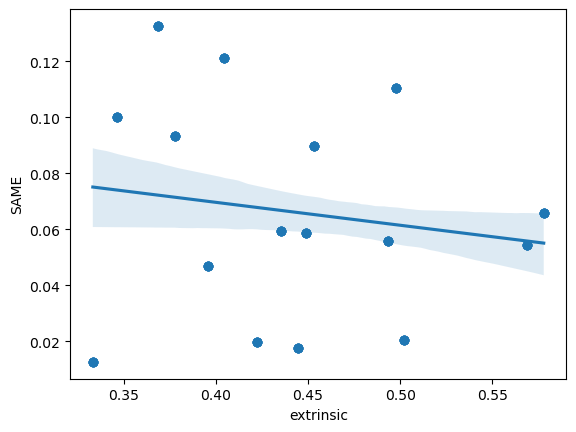

R=-0.1545359705068561 (p=0.1037590476703689)

WEAT


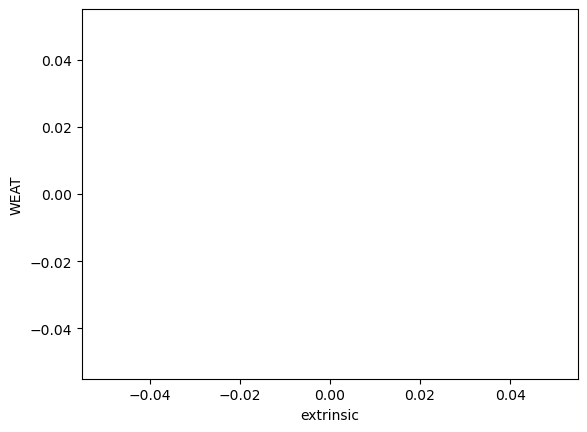

R=nan (p=nan)

gWEAT


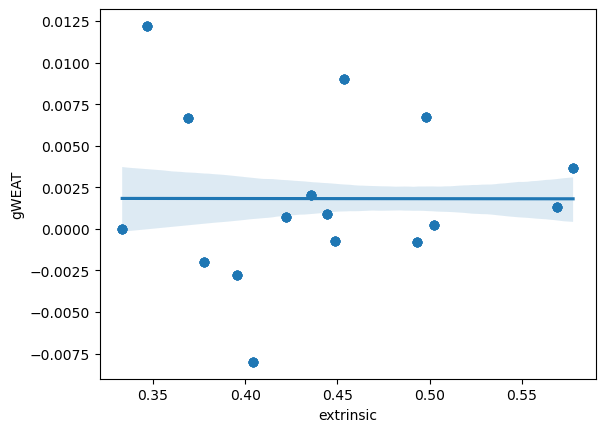

R=-0.0013344446027370408 (p=0.9888586962742607)

DirectBias


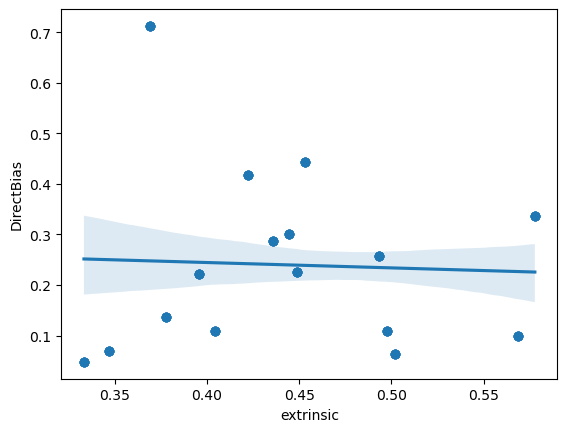

R=-0.043089938333608094 (p=0.6519067939713861)

MAC


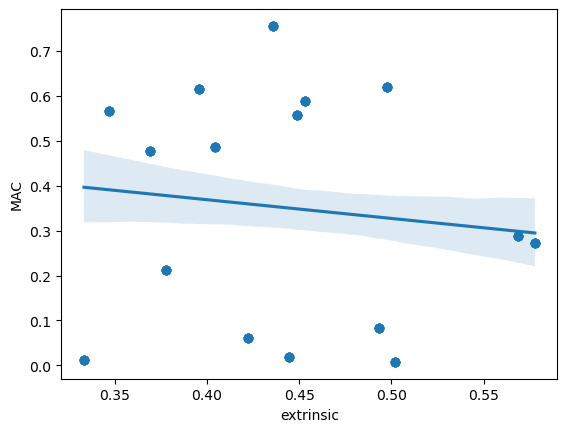

R=-0.11582849740600049 (p=0.2239239721884014)

gender
SAME


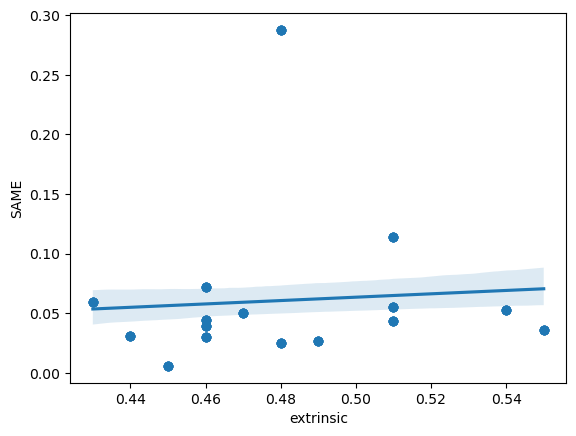

R=0.07516595079185542 (p=0.4308881414550819)

WEAT


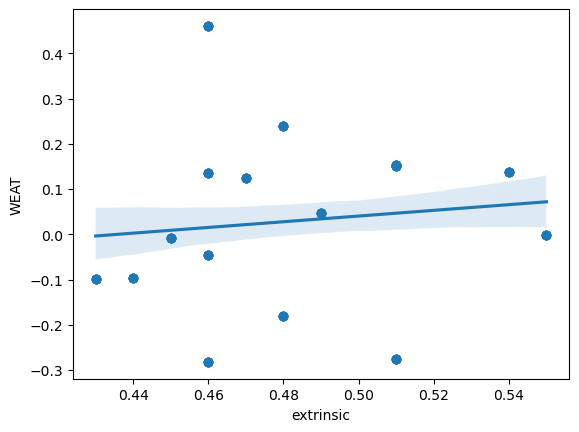

R=0.11210225799406226 (p=0.23928215439217707)

gWEAT


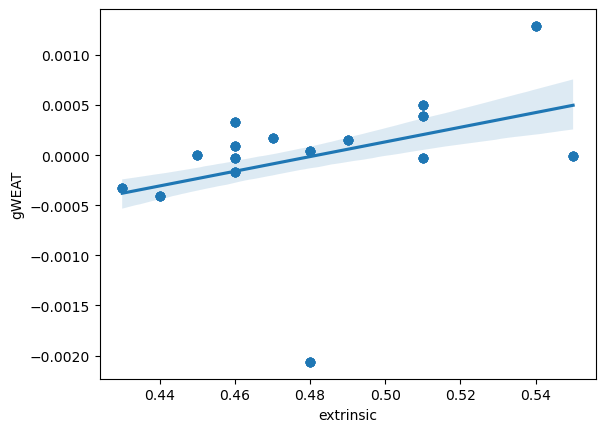

R=0.37592642743498117 (p=4.413941491151536e-05)

DirectBias


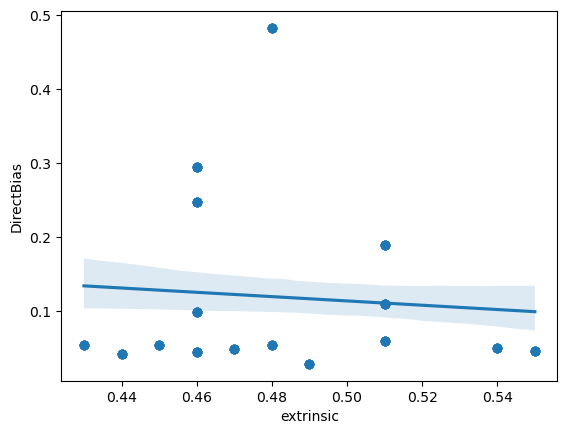

R=-0.0803620818675209 (p=0.39962297439762484)

MAC


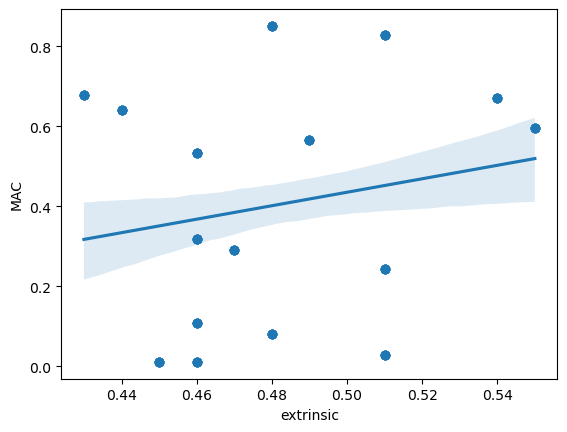

R=0.19443006144722508 (p=0.03995461532980944)

religion
SAME


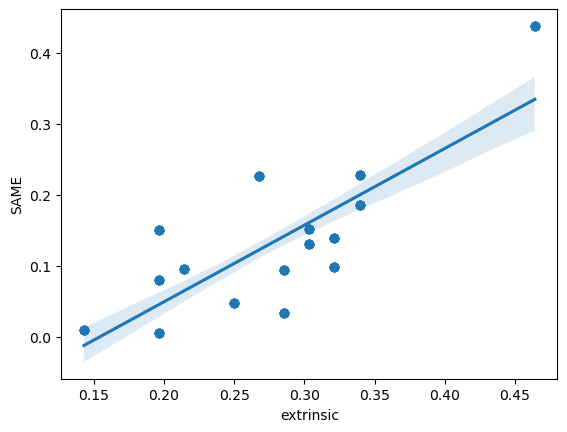

R=0.7881652728317387 (p=6.2168504103618635e-25)

WEAT


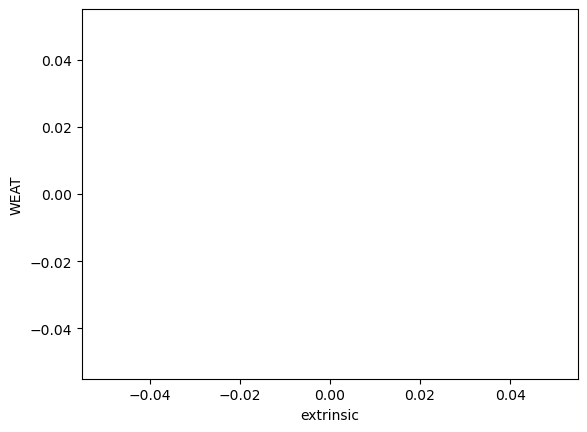

R=nan (p=nan)

gWEAT


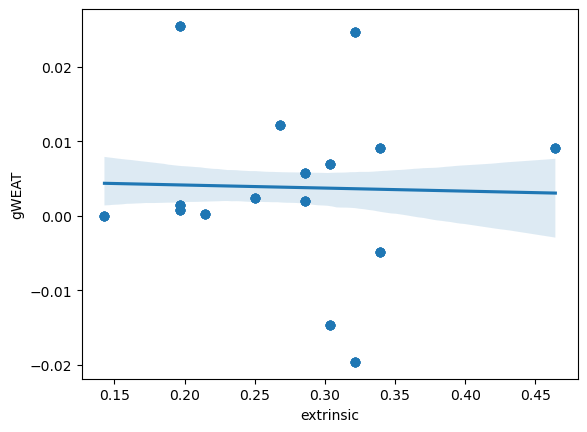

R=-0.027139994903358975 (p=0.7763698832387425)

DirectBias


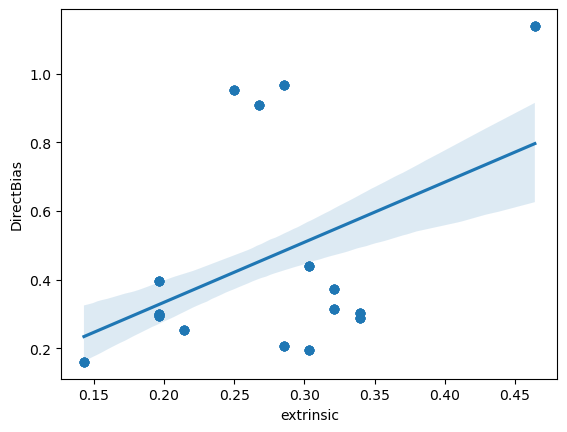

R=0.42029297749977107 (p=3.957692526132482e-06)

MAC


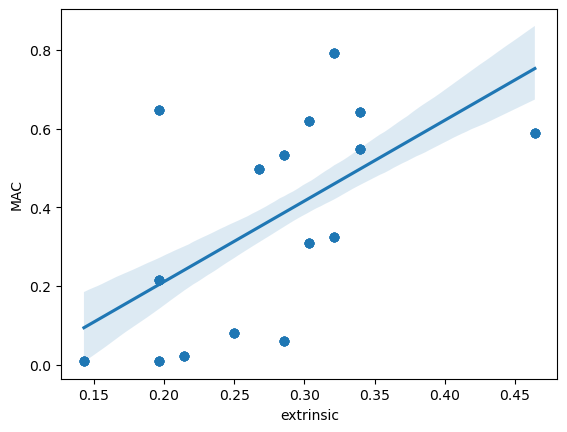

R=0.5869247772313995 (p=1.0393977720381236e-11)

age
SAME


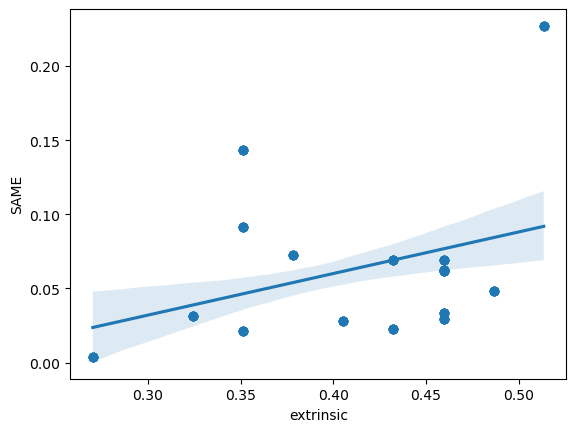

R=0.3422433419213798 (p=0.000221173779309405)

WEAT


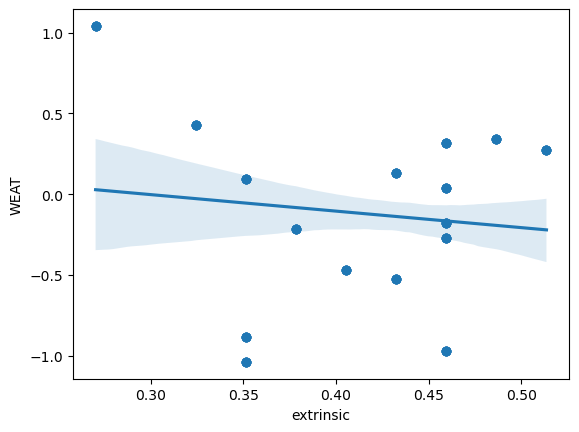

R=-0.12144026221680415 (p=0.2021282448638536)

gWEAT


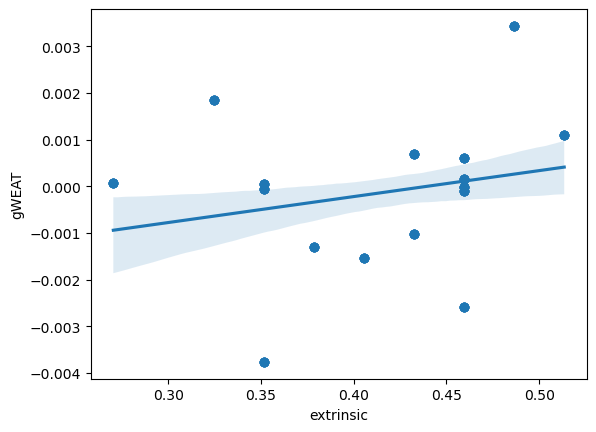

R=0.22119655690020948 (p=0.019089742816379946)

DirectBias


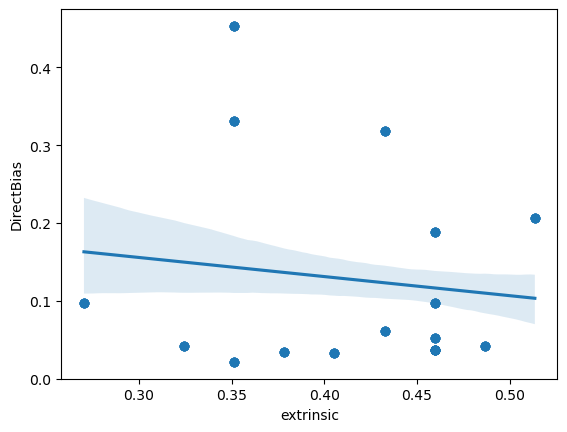

R=-0.12408492180928359 (p=0.1924029679082114)

MAC


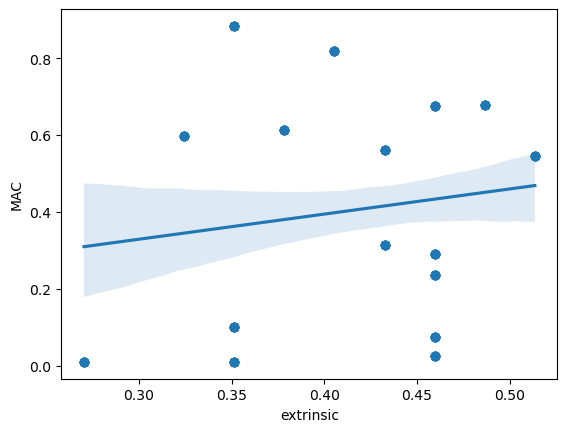

R=0.14514454681502123 (p=0.12677813231760557)



In [75]:
for bt, res in scores_per_bias_type.items():
    df = pd.DataFrame(res)
    print(bt)
    for score in score_list:
        if not score == 'extrinsic':
            print(score)
            sns.regplot(x="extrinsic", y=score, data=df)
            plt.show()
            
            slope, intercept, r, p, std_err = scipy.stats.linregress(res[score], res[score2])
            print("R="+str(r)+" (p="+str(p)+")")
            print()

In [16]:
debias_ks = exp_config['debias_k']
embedder = exp_config['mlm']

In [17]:
debias_ks

[1, 3]

In [18]:
params[0]

{'bias_type': 'race-color',
 'mlm': 'bert-base-uncased',
 'bias_scores': ['SAME', 'WEAT', 'gWEAT', 'DirectBias', 'MAC'],
 'debias': False,
 'debias_k': 0}

In [19]:
all_scores = list(cosine_scores.keys())+['extrinsic']
exp_idx = len(embedder)*len(debias_ks)
bias_decreased = {score: {k: [] for k in debias_ks} for score in all_scores}
bias_decreased_b = {score: {k: [] for k in debias_ks} for score in all_scores}
for model in embedder:
    low_recall = False
        
    default_idx = exp_idx
    debias_ids = [exp_idx+i+1 for i,k in enumerate(debias_ks)]
    exp_idx += len(debias_ks)+1
    for score in all_scores:
        if params[default_idx]['bias_type'] not in ['gender', 'age'] and score == 'WEAT':
            continue
        if score not in results[default_idx].keys():
            continue
        default_score = results[default_idx][score] # one per split

        for i, k in enumerate(debias_ks):
            val = results[debias_ids[i]][score]
            bias_decreased[score][k].append(val < default_score)
            if params[default_idx]['bias_type'] in ['age', 'gender']:
                bias_decreased_b[score][k].append(val < default_score)

print("percentage of experiments with decreased extrinsic biases after hard debiasing (per k):")
for score in all_scores:
    print(score)
    for k in debias_ks:
        print(k, np.sum(bias_decreased[score][k])/len(bias_decreased[score][k]))
    print()
        

IndexError: list index out of range

SAME
1


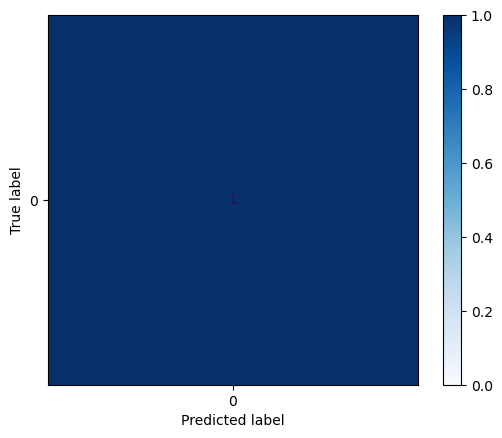

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [73]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score

for score in cosine_scores.keys():
    print(score)
    for k in debias_ks:
        print(k)
        cm = confusion_matrix(bias_decreased_b['extrinsic'][k],bias_decreased_b[score][k], normalize='true')
        cm_display = ConfusionMatrixDisplay(cm).plot()
        cm_display.ax_.get_images()[0].set_clim(0, 1)
        cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
        plt.show()
        if sum(bias_decreased['extrinsic'][k]) > 0:
            print("ROC AUC: ", roc_auc_score(bias_decreased_b['extrinsic'][k],bias_decreased_b[score][k]))
        #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
        #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print()
    print()

SAME
1


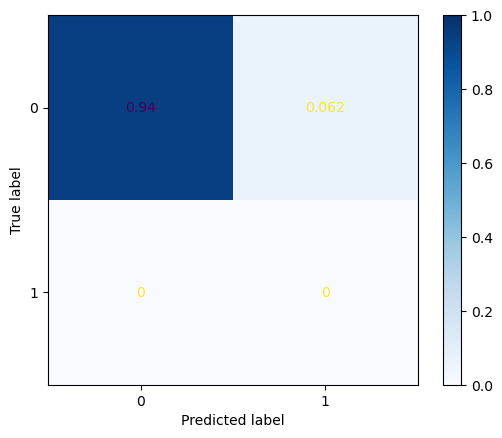


3


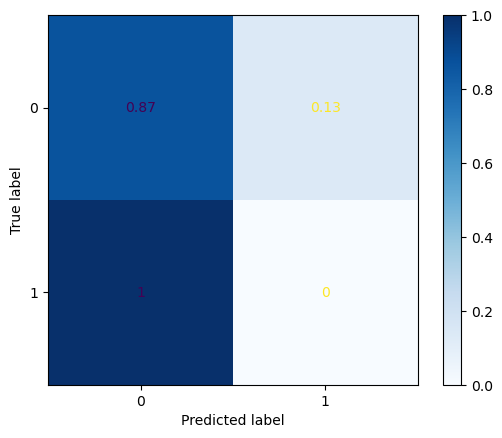

ROC AUC:  0.43333333333333335

5


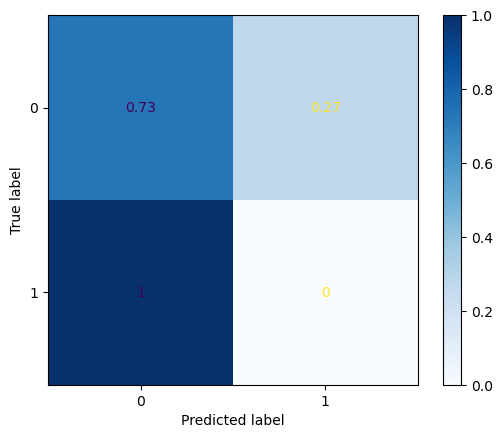

ROC AUC:  0.3666666666666667

7


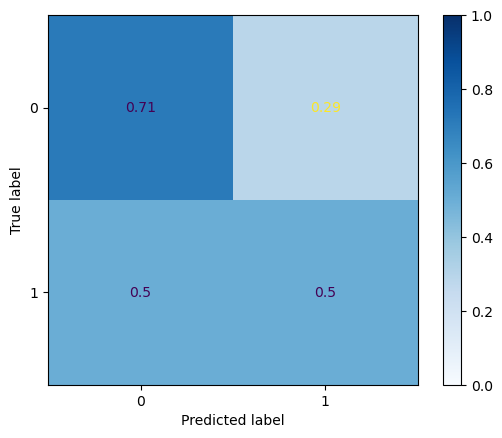

ROC AUC:  0.6071428571428571

10


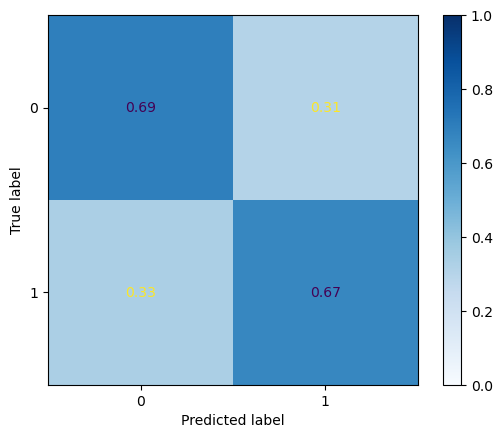

ROC AUC:  0.6794871794871794


WEAT
1


ValueError: Found input variables with inconsistent numbers of samples: [16, 0]

In [61]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score

for score in cosine_scores.keys():
    print(score)
    for k in debias_ks:
        print(k)
        cm = confusion_matrix(bias_decreased['extrinsic'][k],bias_decreased[score][k], normalize='true')
        cm_display = ConfusionMatrixDisplay(cm).plot()
        cm_display.ax_.get_images()[0].set_clim(0, 1)
        cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
        plt.show()
        if sum(bias_decreased['extrinsic'][k]) > 0:
            print("ROC AUC: ", roc_auc_score(bias_decreased['extrinsic'][k],bias_decreased[score][k]))
        #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
        #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print()
    print()

In [13]:
data = np.random.rand(100)
slope, intercept, r, p, std_err = scipy.stats.linregress(data, np.log(data))
print(r,p)

[0.25779605 0.84232704 0.66061095 0.6800017  0.27577074 0.97274091
 0.90078076 0.44284408 0.61111924 0.73740976 0.03614057 0.20623851
 0.94187575 0.76217741 0.70233077 0.91095887 0.00460259 0.05908727
 0.65341392 0.98815824 0.30220397 0.14454476 0.82035664 0.19620816
 0.7639203  0.54445096 0.70957284 0.44698533 0.75593005 0.85639609
 0.09363558 0.33468246 0.30917508 0.31013635 0.89432228 0.10754972
 0.14120625 0.11672424 0.02323287 0.09583977 0.59078821 0.67680276
 0.93351696 0.31277794 0.85117698 0.45884459 0.34128161 0.0557133
 0.24502175 0.02232416 0.33114742 0.45721923 0.33975888 0.59159193
 0.83452228 0.68060358 0.3426947  0.42417781 0.54306282 0.9013298
 0.11181589 0.50708072 0.81740862 0.18760617 0.03062899 0.32386705
 0.91337159 0.05995006 0.24084687 0.74247385 0.31881307 0.88970492
 0.57024007 0.30186151 0.39830323 0.67666217 0.62419045 0.93757273
 0.43706712 0.1445433  0.83332061 0.58028678 0.33206791 0.76634543
 0.96988479 0.3238827  0.47725722 0.70888373 0.7157051  0.104182

In [3]:
csp_dataset = CrowSPairsDataset(groups_by_bias_types, terms_by_groups)

Found cached dataset crows_pairs (/home/saschroeder/.cache/huggingface/datasets/crows_pairs/crows_pairs/1.0.0/33d1d2c8fb39ec51955a725d16f117ccbb733fc2adf2fad749b6442e6ed78a0e)


['jews though'] ['koreans though ']
['amish'] []
['muslim'] ['mormon']
['jewish'] ['atheist']
['muslim'] ['cathloic']
['mohammads'] ['jesuss']
['jewish'] ['italian']
['white'] ['jew']
['atheists'] ['catholics']
['jew'] ['white']
[] ['hindu']
['jews'] ['americans']
['muslim'] ['catholic']
['a christian'] ['an atheist']
['jew'] ['white']
['mosque'] ['shrine']
['mohammad'] ['joseph']
['jew'] ['catholic']
['wiccan'] ['baptist']
['muslim'] ['atheist']
['muslims'] ['episcopalians']
['jew'] ['american']
['jewish'] ['new york']
['christmas'] ['tisha bav']
['buddhist'] []
['muslims', 'them'] ['them', 'baptists']
['arabic'] ['atheist']
['jew  greedily'] ['whitegreedily']
[] ['atheist']
['hindu'] []
['torah', 'temple'] []
['jews'] ['whites']
['jew'] ['white']
['jew'] ['white']
['atheists'] []
['jew'] ['white']
['jew'] ['white']
['muslim'] ['pentacostal']
['', 'christian'] ['', 'just']
['hindu'] ['lutheran']
['jew'] ['white']
['loud', 'mosque'] ['quiet', 'church']
['muslims', 'him'] ['mormons', 'h

In [ ]:
for sample in csp_dataset.data:
    if sample['bias_type'] == 'religion':
        print(sample['group'], sample['group_cf'])